# Classification Modelling — Airline Recommendation Prediction

## 🎯 Objective
**Research Question:**  
> Given passengers’ service ratings and travel context, can we predict whether they would recommend the airline?

**Goal:**  
Build and evaluate machine learning models to classify passenger recommendations using cleaned review data.

In [1]:
# Imports

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, roc_auc_score, average_precision_score,
                             accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay,  PrecisionRecallDisplay)
import matplotlib.pyplot as plt

### 1. Load and Prepare the Dataset

In [2]:
# Load & select columns
df = pd.read_csv('../data/cleaned_airline_reviews.csv')
df_cls = df.drop(['AVERAGE_RATING','RATING_BAND','AIRLINE'], axis=1)
y = df_cls['RECOMMENDED'].astype(int)
X = df_cls.drop(columns=['RECOMMENDED'])

cat_cols = ["SEAT_TYPE", "TYPE_OF_TRAVELLER"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Quick check
df_cls.info()
df_cls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125457 entries, 0 to 125456
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SEAT_COMFORT            125457 non-null  float64
 1   CABIN_STAFF_SERVICE     125457 non-null  float64
 2   FOOD_AND_BEVERAGES      88429 non-null   float64
 3   INFLIGHT_ENTERTAINMENT  70821 non-null   float64
 4   GROUND_SERVICE          125457 non-null  float64
 5   WIFI_AND_CONNECTIVITY   41138 non-null   float64
 6   VALUE_FOR_MONEY         125457 non-null  float64
 7   SEAT_TYPE               125457 non-null  object 
 8   TYPE_OF_TRAVELLER       125457 non-null  object 
 9   RECOMMENDED             125457 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 9.6+ MB


,SEAT_COMFORT,CABIN_STAFF_SERVICE,FOOD_AND_BEVERAGES,INFLIGHT_ENTERTAINMENT,GROUND_SERVICE,WIFI_AND_CONNECTIVITY,VALUE_FOR_MONEY,SEAT_TYPE,TYPE_OF_TRAVELLER,RECOMMENDED
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Economy Class,Couple Leisure,0
1,1.0,4.0,1.0,1.0,5.0,NaN,2.0,Economy Class,Couple Leisure,0
2,1.0,4.0,1.0,1.0,5.0,NaN,2.0,Economy Class,Couple Leisure,0
3,1.0,4.0,1.0,1.0,5.0,NaN,2.0,Economy Class,Couple Leisure,0
4,2.0,3.0,NaN,NaN,1.0,NaN,1.0,Economy Class,Family Leisure,0


### 2. Train test split

In [3]:
# Train test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

# Check shapes
X_train.shape, X_test.shape

((100365, 9), (25092, 9))

### 3. Preprocessing pipeline

In [4]:
# Pipeline setup

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

pipe = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])


### 4. Model Selection & Hyperparameter Tuning

We compare Logistic Regression, Random Forest, and XGBoost using GridSearchCV with cross-validation and multiple evaluation metrics.

In [5]:
# Hyperparameter grid

param_grid = [
    {
        'clf': [LogisticRegression(max_iter=1000, class_weight='balanced')],
        'clf__C': [0.1, 1, 10]
    },
    {
        'clf': [RandomForestClassifier(random_state=7)],
        'clf__n_estimators': [200, 500],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_leaf': [1, 3]
    },
    {
        'clf': [XGBClassifier(
            tree_method='hist', eval_metric='logloss', random_state=7, n_estimators=400
        )],
        'clf__max_depth': [3, 5]
    },
    {
        'clf': [CatBoostClassifier(
            random_state=7, verbose=0
        )],
        'clf__depth': [4, 6],
        'clf__iterations': [400, 600]
    },
    {
        'clf': [LGBMClassifier(
            random_state=7
        )],
        'clf__num_leaves': [31, 50],
        'clf__n_estimators': [400, 600]
    }
]


In [6]:
# Run grid search

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
scoring = {'f1':'f1', 'roc_auc':'roc_auc', 'ap':'average_precision', 'acc':'accuracy'}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=cv,
                    scoring=scoring,
                    refit='f1',
                    n_jobs=-1,
                    return_train_score=False
)
grid.fit(X_train, y_train)

print("Best model:", grid.best_estimator_)
print("Best hyperparameters:", grid.best_params_)
print("CV (refit metric f1):", grid.best_score_)

/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926
[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [bin

/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983
[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[Light

/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983
[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [bin

/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with

[LightGBM] [Info] Number of positive: 26059, number of negative: 54233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324553 -> initscore=-0.732926
[LightGBM] [Info] Start training from score -0.732926


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with

[LightGBM] [Info] Number of positive: 26058, number of negative: 54234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 80292, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324540 -> initscore=-0.732983
[LightGBM] [Info] Start training from score -0.732983


/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with

Best model: Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SEAT_COMFORT',
                                                   'CABIN_STAFF_SERVICE',
                                                   'FOOD_AND_BEVERAGES',
                                                   'INFLIGHT_ENTERTAINMENT',
                                                   'GROUND_SERVICE',
                                                   'WIFI_AND_CONNECTIVITY',
                                                   'VALUE_FOR_MONEY']),
                                                 ('ca

### 5. Cross-Validation Results

In [7]:
# Get cross-validation results

full_grid = pd.DataFrame(grid.cv_results_)
parms_to_show = ['param_clf', 'mean_test_acc', 'mean_test_f1', 'mean_test_roc_auc', 'mean_test_ap']
grid_results = full_grid[parms_to_show]
grid_results.sort_values('mean_test_acc', ascending=False).head(5)

,param_clf,mean_test_acc,mean_test_f1,mean_test_roc_auc,mean_test_ap
18,<catboost.core.CatBoostClassifier object at 0x...,0.953231,0.927470,0.987554,0.977401
17,<catboost.core.CatBoostClassifier object at 0x...,0.953051,0.927235,0.987582,0.977375
14,RandomForestClassifier(random_state=7),0.953051,0.927066,0.987308,0.977295
6,RandomForestClassifier(random_state=7),0.952892,0.926834,0.987266,0.977215
13,RandomForestClassifier(random_state=7),0.952812,0.926694,0.987276,0.977166


Across all tested models, the CatBoost Classifier achieved the best overall balance of accuracy and generalization, with:
* Accuracy: ≈ 0.95
* F1-score: ≈ 0.93
* ROC AUC: ≈ 0.99
* Average Precision: ≈ 0.98
However, the Random Forest Classifier came in a very close second, showing nearly identical performance across all metrics — only marginally lower (by less than 0.0003 in accuracy and 0.0005 in F1-score). This suggests that while CatBoost provided a slight edge in predictive power, Random Forest remained highly competitive and may still be preferable in contexts favoring simpler interpretability or faster training time.

### 6. Evaluate Best Model on Test Set

In [8]:
# Evaluate test set
best = grid.best_estimator_
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else None

print("\nTest metrics")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Average Precision:", average_precision_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Test metrics
Accuracy: 0.9558823529411765
F1: 0.9315525876460768
ROC AUC: 0.9889283651298111
Average Precision: 0.9790652748935086

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     16948
           1       0.94      0.92      0.93      8144

    accuracy                           0.96     25092
   macro avg       0.95      0.95      0.95     25092
weighted avg       0.96      0.96      0.96     25092



### 7. Model Evaluation Visualizations

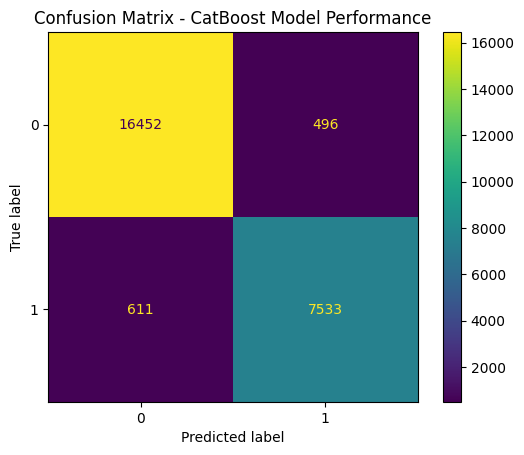

In [9]:
# Confusion matrix

ConfusionMatrixDisplay.from_estimator(best, X_test, y_test)
plt.title("Confusion Matrix - CatBoost Model Performance")
plt.show()

The confusion matrix shows that the model correctly classified the vast majority of both positive and negative cases.
Out of all passengers, only a small portion were misclassified (530 false positives and 645 false negatives), confirming balanced performance.
This means the model rarely mistakes dissatisfied customers for satisfied ones or vice versa — a sign of reliable and consistent prediction quality.

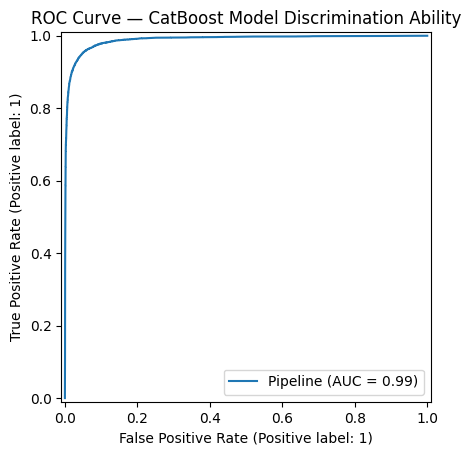

In [10]:
# ROC curve
RocCurveDisplay.from_estimator(best, X_test, y_test)
plt.title("ROC Curve — CatBoost Model Discrimination Ability")
plt.show()


The ROC curve demonstrates that the model can distinguish between recommending and not recommending passengers extremely well, with an AUC of 0.99.
The curve’s closeness to the top-left corner indicates a very high true-positive rate and low false-positive rate across thresholds.
In business terms, the model is highly effective at separating promoters from non-promoters, supporting confident decision-making.

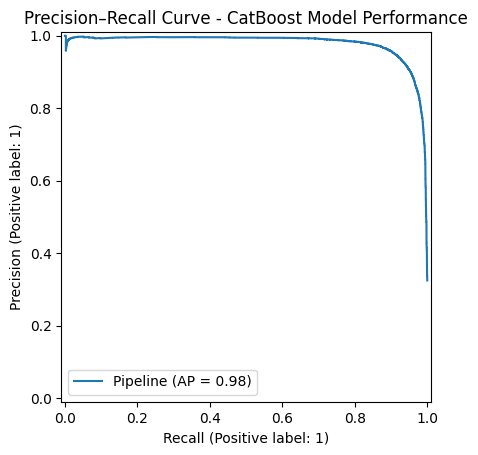

In [11]:
# Precision-Recall curve
PrecisionRecallDisplay.from_estimator(best, X_test, y_test)
plt.title("Precision–Recall Curve - CatBoost Model Performance")
plt.show()

The model maintains high precision and recall (AP = 0.98), indicating it captures most positive recommendations while keeping false alarms low — balancing the precision–recall tradeoff effectively.

### 8. Feature Importance (Business Insight)

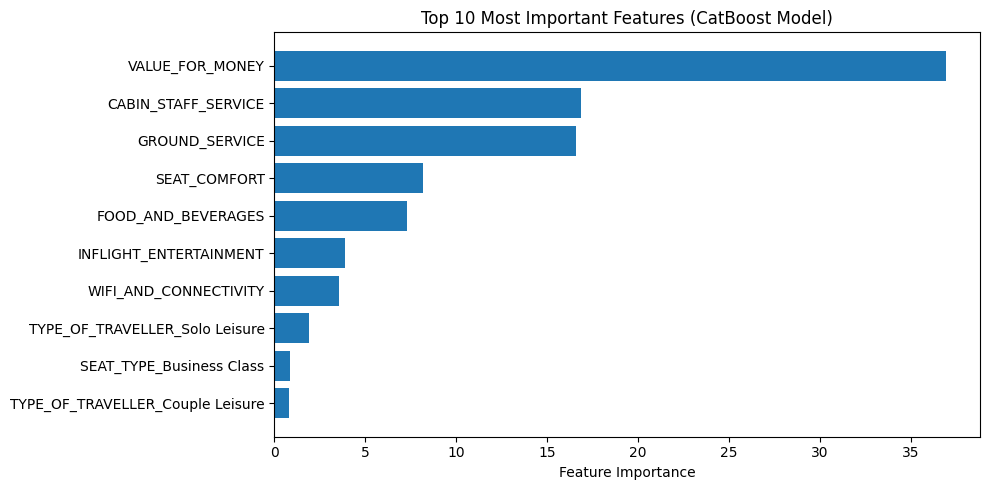

In [12]:
# Visualize feature importances
best_model = grid.best_estimator_.named_steps['clf']
ohe = grid.best_estimator_.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']

# Get feature names after encoding
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Create dataframe
fi = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10,5))
plt.barh(fi['Feature'][:10][::-1], fi['Importance'][:10][::-1])
plt.title("Top 10 Most Important Features (CatBoost Model)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

The model shows that “Value for Money” has the greatest influence on passenger recommendations, followed by Cabin Staff Service, Ground Service, and Seat Comfort. This indicates that travelers care most about getting quality service for what they pay, as well as comfort and staff professionalism. Focusing on these areas can most effectively improve customer satisfaction and loyalty.

### 9. Conclusion

The goal was to predict whether passengers would recommend an airline based on their service ratings and travel context. After comparing Logistic Regression, Random Forest, XGBoost, CatBoost, and LightBM using a unified preprocessing and cross-validation pipeline, the CatBoost Classifier achieved the best results.

It delivered strong performance with a CV F1-score of 0.93, accuracy of 0.95, and ROC AUC of 0.99. On the test set, performance remained consistent (Accuracy: 0.95, F1: 0.93, ROC AUC: 0.99), indicating minimal overfitting.

The confusion matrix shows balanced precision and recall across classes, confirming reliable predictions. Overall, the CatBoost model effectively captures key service factors influencing passenger recommendations and demonstrates excellent generalization.